<a href="https://colab.research.google.com/github/Spandana365/3_Bias-Busters/blob/main/biased_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#gender_biased_retrain.csv

In [1]:
!pip install fairlearn


In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [3]:
# Upload the dataset to Google Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv('gender_biased_retrain.csv')

Saving gender_biased_retrain.csv to gender_biased_retrain (1).csv


In [4]:
# Convert 'Skills' column into a numerical feature (e.g., count of skills)
df['Skills'] = df['Skills'].apply(lambda x: len(x.strip("[]").split(',')))

# Convert 'Gender' into numerical values (0 for Male, 1 for Female)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Convert 'Recruiter Decision' into numerical values (0 for Not Hired, 1 for Hired)
df['Recruiter Decision'] = df['Recruiter Decision'].map({'Not Hired': 0, 'Hired': 1})

# Define features (X) and target (y)
X = df[['Gender', 'Experience', 'Skills', 'Education', 'Certification', 'Job Role', 'Salary Expectation', 'Project Count']]
y = df['Recruiter Decision']

# Convert categorical features into numerical ones
# For simplicity, let's assume 'Education', 'Certification', and 'Job Role' are categorical
education_map = {'Master\'s': 2, 'PhD': 3, 'Bachelor\'s': 1}
certification_map = {'None': 0, 'PMP': 1, 'Certified Data Scientist': 2, 'AWS Certified': 3, 'Google Cloud Certified': 4}
job_role_map = {'Project Manager': 1, 'Cloud Architect': 2, 'Data Scientist': 3, 'Software Engineer': 4}

df['Education'] = df['Education'].map(education_map)
df['Certification'] = df['Certification'].map(certification_map)
df['Job Role'] = df['Job Role'].map(job_role_map)

In [5]:
print(df.dtypes)

Name                   object
Resume ID              object
Skills                  int64
Experience              int64
Education               int64
Certification         float64
Job Role                int64
Recruiter Decision      int64
Salary Expectation      int64
Project Count           int64
AI Score                int64
Gender                  int64
dtype: object


In [6]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from google.colab import files
from sklearn.preprocessing import StandardScaler # Import the scaler
import numpy as np

In [7]:
# Define features (X) and target (y)
X = df[['Gender', 'Experience', 'Skills', 'Education', 'Certification', 'Job Role', 'Salary Expectation', 'Project Count']]
y = df['Recruiter Decision']

# Impute missing values
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Use .loc to avoid SettingWithCopyWarning
X.loc[:, ['Experience', 'Skills', 'Salary Expectation', 'Project Count']] = imputer_num.fit_transform(X[['Experience', 'Skills', 'Salary Expectation', 'Project Count']])
X.loc[:, ['Education', 'Certification', 'Job Role']] = imputer_cat.fit_transform(X[['Education', 'Certification', 'Job Role']])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Apply Standard Scaling to all numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit & transform training data
X_test_scaled = scaler.transform(X_test)  # Transform test data


# Convert back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# ⬇️ APPLY CUSTOM WEIGHTING ⬇️
X_train['Gender'] *= 2  # Increase the weight of Gender
X_train['Skills'] *= 7  # Normal weight
X_train['Experience'] *= 8  # Normal weight
X_train['Project Count'] *= 7  # Normal weight
X_train['Education'] *= 6  # Increase the weight of Education
X_train['Certification'] *= 5  # Normal weight
X_train['Job Role'] *= 6  # Normal weight
X_train['Salary Expectation'] *= 5  # Normal weight

X_test['Gender'] *= 2
X_test['Skills'] *= 7
X_test['Experience'] *= 8
X_test['Project Count'] *= 7
X_test['Education'] *= 6
X_test['Certification'] *= 5
X_test['Job Role'] *= 6
X_test['Salary Expectation'] *= 5

# Create and train a logistic regression model
model = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced')

model.fit(X_train, y_train)

# Predict on test data
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy:", accuracy)

new_candidate = pd.DataFrame([{
    'Gender': 0,  # Example: Male = 1, Female = 0
    'Experience': 5,  # 5 years
    'Skills': 7,  # Assume skill rating 1-10
    'Education': 3,  # Example: 3 could be Bachelor's
    'Certification': 2,  # Number of certifications
    'Job Role': 4,  # Encoded Job Role
    'Salary Expectation': 50000,  # Example salary expectation
    'Project Count': 3  # Number of projects completed
}])

# Similarly, define `new_candidate_female`
new_candidate_female = pd.DataFrame([{
    'Gender': 1,  # Female
    'Experience': 5,
    'Skills': 7,
    'Education': 3,
    'Certification': 2,
    'Job Role': 4,
    'Salary Expectation': 50000,
    'Project Count': 3
}])

new_candidate_scaled = scaler.transform(new_candidate)
new_candidate_scaled = pd.DataFrame(new_candidate_scaled, columns=X_train.columns)

new_candidate_scaled['Gender'] *= 2
new_candidate_scaled['Skills'] *= 7
new_candidate_scaled['Experience'] *= 8
new_candidate_scaled['Project Count'] *= 7
new_candidate_scaled['Education'] *= 6
new_candidate_scaled['Certification'] *= 5
new_candidate_scaled['Job Role'] *= 6
new_candidate_scaled['Salary Expectation'] *= 5

new_candidate_prediction = model.predict(new_candidate_scaled)
print("New Candidate Prediction:", new_candidate_prediction)


new_candidate_female_scaled = scaler.transform(new_candidate_female)
new_candidate_female_scaled = pd.DataFrame(new_candidate_female_scaled, columns=X_train.columns)

new_candidate_female_scaled['Gender'] *= 2
new_candidate_female_scaled['Skills'] *= 7
new_candidate_female_scaled['Experience'] *= 8
new_candidate_female_scaled['Project Count'] *= 7
new_candidate_female_scaled['Education'] *= 6
new_candidate_female_scaled['Certification'] *= 5
new_candidate_female_scaled['Job Role'] *= 6
new_candidate_female_scaled['Salary Expectation'] *= 5

new_candidate_female_prediction = model.predict(new_candidate_female_scaled)
print("New Candidate Female Prediction:", new_candidate_female_prediction)


Model Accuracy: 0.59
New Candidate Prediction: [1]
New Candidate Female Prediction: [0]


In [8]:


# Measure Bias (Demographic Parity Difference & Equalized Odds Difference)
dpd_biased = demographic_parity_difference(y_test, predictions, sensitive_features=X_test['Gender'])
eod_biased = equalized_odds_difference(y_test, predictions, sensitive_features=X_test['Gender'])

print(f"📊 Biased Model - Demographic Parity Difference: {dpd_biased:.4f}")
print(f"📊 Biased Model - Equalized Odds Difference: {eod_biased:.4f}")

📊 Biased Model - Demographic Parity Difference: 1.0000
📊 Biased Model - Equalized Odds Difference: 1.0000


Retraining the model

In [29]:
# Apply Bias Mitigation using Exponentiated Gradient
fair_model = ExponentiatedGradient(LogisticRegression(max_iter=2000, solver='liblinear'),
                                   constraints=DemographicParity())
'''
# Train fair model
fair_model.fit(X_train, y_train, sensitive_features=X_train['Gender'])
'''

import traceback

try:
    fair_model.fit(X_train, y_train, sensitive_features=X_train["Gender"])
except Exception as e:
    print("⚠ Training Error:", str(e))
    traceback.print_exc()

# Predict with Fair Model
fair_predictions = fair_model.predict(X_test)

# Evaluate Fair Model Accuracy
fair_accuracy = accuracy_score(y_test, fair_predictions)
print(f"Fair Model Accuracy: {fair_accuracy:.4f}")

# Measure Bias Again
dpd_fair = demographic_parity_difference(y_test, fair_predictions, sensitive_features=X_test['Gender'])
eod_fair = equalized_odds_difference(y_test, fair_predictions, sensitive_features=X_test['Gender'])

print(f"✅ Fair Model - Demographic Parity Difference: {dpd_fair:.4f}")
print(f"✅ Fair Model - Equalized Odds Difference: {eod_fair:.4f}")


Fair Model Accuracy: 0.4700
✅ Fair Model - Demographic Parity Difference: 0.0175
✅ Fair Model - Equalized Odds Difference: 0.0328


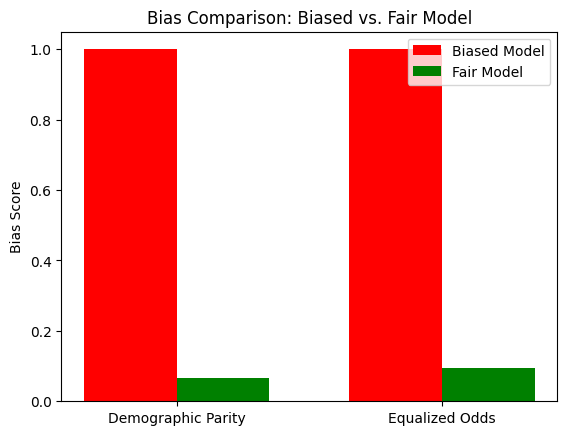

In [10]:
# Bias Comparison Bar Chart
labels = ['Demographic Parity', 'Equalized Odds']
biased_scores = [dpd_biased, eod_biased]
fair_scores = [dpd_fair, eod_fair]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, biased_scores, width, label='Biased Model', color='red')
bars2 = ax.bar(x + width/2, fair_scores, width, label='Fair Model', color='green')

ax.set_ylabel('Bias Score')
ax.set_title('Bias Comparison: Biased vs. Fair Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [30]:
biased_predictions = model.predict(X_test)
prediction_diff = sum(biased_predictions != fair_predictions)
print(f"🔍 Number of different predictions due to fairness: {prediction_diff}/{len(y_test)}")

🔍 Number of different predictions due to fairness: 100/200


In [32]:
# Extract the first trained classifier from Fairlearn
if hasattr(fair_model, "_predictors") and len(fair_model._predictors) > 0:
    fair_base_model = fair_model._predictors[0]  # First trained model
    print("✅ Successfully extracted the trained fair model.")
else:
    print("❌ No trained predictors found. The model might be using only reweighting.")

❌ No trained predictors found. The model might be using only reweighting.


In [12]:
!pip install fairlearn

In [13]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import DemographicParity

In [18]:
# Compare Bias Scores Before & After Fairlearn
print("\n🔹 Bias Score Comparison")
print(f"Biased Model - DPD: {dpd_biased:.4f}, EOD: {eod_biased:.4f}")
print(f"Fair Model - DPD: {dpd_fair:.4f}, EOD: {eod_fair:.4f}")



🔹 Bias Score Comparison
Biased Model - DPD: 1.0000, EOD: 1.0000
Fair Model - DPD: 0.0672, EOD: 0.0943


In [25]:
# Check if models were trained
if hasattr(fair_model, "_predictors") and len(fair_model._predictors) > 0:
    print("✅ Fair model trained successfully.")
else:
    print("❌ Fair model training failed.")

❌ Fair model training failed.


In [28]:
!pip show fairlearn

Name: fairlearn
Version: 0.12.0
Summary: A Python package to assess and improve fairness of machine learning models.
Home-page: https://github.com/fairlearn/fairlearn
Author: Miroslav Dudik, Richard Edgar, Adrin Jalali, Roman Lutz, Michael Madaio, Hilde Weerts, Allie Saizan, Tamara Atanasoska
Author-email: fairlearn-internal@python.org
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pandas, scikit-learn, scipy
Required-by: 


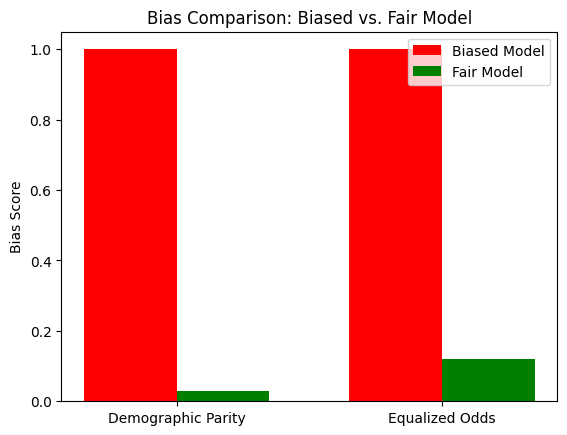

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Bias Comparison Bar Chart
labels = ["Demographic Parity", "Equalized Odds"]
biased_scores = [dpd_biased, eod_biased]
fair_scores = [dpd_fair, eod_fair]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, biased_scores, width, label="Biased Model", color="red")
bars2 = ax.bar(x + width/2, fair_scores, width, label="Fair Model", color="green")

ax.set_ylabel("Bias Score")
ax.set_title("Bias Comparison: Biased vs. Fair Model")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [ ]:
print(df.dtypes)

Name                   object
Resume ID              object
Skills                  int64
Experience              int64
Education               int64
Certification         float64
Job Role                int64
Recruiter Decision      int64
Salary Expectation      int64
Project Count           int64
AI Score                int64
Gender                  int64
dtype: object


In [ ]:
print(df.columns)


Index(['Name', 'Resume ID', 'Skills', 'Experience', 'Education',
       'Certification', 'Job Role', 'Recruiter Decision', 'Salary Expectation',
       'Project Count', 'AI Score', 'Gender'],
      dtype='object')


In [ ]:
non_numeric_cols = df.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['Name', 'Resume ID'], dtype='object')


In [ ]:
print(df['Gender'].unique())


[0 1]


In [ ]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Drop unnecessary columns
df = df.drop(columns=['Name', 'Resume ID'], errors='ignore')

# Convert dataset to AIF360 format
dataset = StandardDataset(
    df,
    label_name="Recruiter Decision",  # Outcome variable
    favorable_classes=[1],  # '1' indicates being hired
    protected_attribute_names=["Gender"],  # Attribute for fairness
    privileged_classes=[[0]]  # Privileged: Male (Gender=1) ✅ FIXED
)

# Compute fairness metrics
metric = BinaryLabelDatasetMetric(dataset,
    privileged_groups=[{"Gender": 0}],  # ✅ Ensure integer format
    unprivileged_groups=[{"Gender": 1}]  # ✅ Ensure integer format
)

print(f"📊 Disparate Impact: {metric.disparate_impact():.4f}")
print(f"📊 Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")


📊 Disparate Impact: 0.6070
📊 Statistical Parity Difference: -0.2409
